# Sensor Data - Data Scientist Assignment
*Niko Draganić*

#### Opis zadatka

> Dani su podatci prikupljeni iz različitih senzora automobila u razdoblju od 1.1.2020. do 23.6.2020.
Potrebno je analizirati dani set podataka i predvidjeti koji će senzori u narednih 7 dana prestati raditi.
Točnije,iz danih podataka potrebno je izračunati failure rate senzora i napraviti prediktivni model za prestanak rada senzora (failure prediction).

#### Kratak opis rješenja
Za početak sam provjerio i analizirao sadržaj, metrike i distribuciju varijabli. Uočio sam da je zastupljenost kvarova u podacima vrlo mala (manja od 1:15000) te da su dodatno modeli senzora, koji prema vlastitoj logici pune podatke u varijable, vrlo neravnomjerno brojčano raspoređeni.  
Dodatnom usporedbom zaključio sam da postoje modeli senzora koji su iznimno kvarljivi, kao i modeli koji se iznimno rijetko kvare. Zbog toga sam odlučio ne tretirati dataset kao cjelinu, nego razbiti ga na grupe i to koristeći UMAP transformaciju kako bih iz višedimenzionalnih podataka dobio 2D projekciju. 
Naknadno sam i *resampling* metodom SMOTE povećao (sintetizirao) broj uzoraka koji predstavljaju kvar. Na kraju sam trenirao modele koristeći XGBoost gradijentni boosting, najprije pojedinačno na grupiranim podacima i svim indikatorima, a zatim i na svim podacima uz primjenu indikatora koji su u zadatku označeni kao prediktivni. U oba slučaja sam dobio točnost modela (za cjelinu) od oko 88%.

U nastavku je detaljan kod kako sam pristupio rješavanju zadatka. Notebook je dostupan na [github-u](https://github.com/ndraganic/2020_sensors/), a cijelo rješenje, uključujući i podatke na [deepnote-u](https://beta.deepnote.com/project/ec00c6c0-46e3-4d3f-b21d-ddedb5b5b33a).

#### Zaključak
Jedan korak kojeg sam htio, ali nisam stigao napraviti, nakon što sam koristeći XGBoost dobio značajne indikatore bio je generiranje moving average-a, i sličnih analitičkih indikatora te ponovno treniranje modela. Za prvu ruku, zadovoljan sam rješenjem kojeg nudim u nastavku.


In [1]:
# imports
import pandas as pd
import numpy as np

import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px

import datetime

import umap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

## Data Exploration
Na početku svakog DS projekta potrebno je upoznati se s podacima - doznati domene varijabli, distribucije podataka i eventualno logičke odnose između njih. Ovime dobivamo značajne informacije koje nam pomažu u kasnijem postavljanju i interpretaciji modela.

Za početak odabirem proizvoljnu datoteku sa podacima na jedan datum.

In [2]:
# reading the data
df = pd.read_csv('2020-03-11.csv')
df.head()

,date,serial_number,type,capacity,failure,stat_1_normalized,stat_1_raw,stat_2_normalized,stat_2_raw,stat_3_normalized,...,stat_250_normalized,stat_250_raw,stat_251_normalized,stat_251_raw,stat_252_normalized,stat_252_raw,stat_254_normalized,stat_254_raw,stat_255_normalized,stat_255_raw
0,2020-03-11,MJ0351YNG9Z0XA,HDS5C3030ALA630,3000592982016,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-11,Z305B2QN,ST4000DM000,4000787030016,0,116,109628640,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-11,MJ0351YNG9Z7LA,HDS5C3030ALA630,3000592982016,0,100,0,136.0,104.0,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-11,MJ0351YNGABYAA,HDS5C3030ALA630,3000592982016,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-11,WD-WMC4N2899475,WD30EFRX,3000592982016,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.tail()

,date,serial_number,type,capacity,failure,stat_1_normalized,stat_1_raw,stat_2_normalized,stat_2_raw,stat_3_normalized,...,stat_250_normalized,stat_250_raw,stat_251_normalized,stat_251_raw,stat_252_normalized,stat_252_raw,stat_254_normalized,stat_254_raw,stat_255_normalized,stat_255_raw
62318,2020-03-11,Z3016V0V,ST4000DM000,4000787030016,0,120,243439816,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62319,2020-03-11,MJ1323YNG1LZJC,HDS5C3030ALA630,3000592982016,0,100,0,100.0,0.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62320,2020-03-11,Z301EVVA,ST4000DM000,4000787030016,0,117,145926776,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62321,2020-03-11,S300YQMQ,ST4000DM000,4000787030016,0,120,242667368,NaN,NaN,97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62322,2020-03-11,Z304Z66M,ST4000DM000,4000787030016,0,116,114684960,NaN,NaN,97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Provjeravam koje varijable se nalaze u *datasetu*:

In [4]:
df.columns

Index(['date', 'serial_number', 'type', 'capacity', 'failure',
       'stat_1_normalized', 'stat_1_raw', 'stat_2_normalized', 'stat_2_raw',
       'stat_3_normalized', 'stat_3_raw', 'stat_4_normalized', 'stat_4_raw',
       'stat_5_normalized', 'stat_5_raw', 'stat_7_normalized', 'stat_7_raw',
       'stat_8_normalized', 'stat_8_raw', 'stat_9_normalized', 'stat_9_raw',
       'stat_10_normalized', 'stat_10_raw', 'stat_11_normalized',
       'stat_11_raw', 'stat_12_normalized', 'stat_12_raw',
       'stat_13_normalized', 'stat_13_raw', 'stat_15_normalized',
       'stat_15_raw', 'stat_22_normalized', 'stat_22_raw',
       'stat_183_normalized', 'stat_183_raw', 'stat_184_normalized',
       'stat_184_raw', 'stat_187_normalized', 'stat_187_raw',
       'stat_188_normalized', 'stat_188_raw', 'stat_189_normalized',
       'stat_189_raw', 'stat_190_normalized', 'stat_190_raw',
       'stat_191_normalized', 'stat_191_raw', 'stat_192_normalized',
       'stat_192_raw', 'stat_193_normalized', 's

Varijable su detaljnije opisane u zadatku:

> Svaki dnevni zapis pojedinog senzora sadrži podatke:
+ date - datum snapshota, format: yyyy-mm-dd
+ serial_number - serijski broj senzora
+ type - tip senzora
+ capacity - kapacitet
+ failure - “0” ako je senzor ispravan, “1” ako je to zadnji dan kada je senzor ispravno
radio
+ stat_n_normalized i stat_n_raw - ukupno 90 stupaca za 45 različitih statistika koje
generira pojedini senzor (45 raw i 45 normalized vrijednosti)

Postavlja se pitanje je li bolje koristiti sirove ili normalizirane podatke. Odgovor ću probati naći tokom idućih par poglavlja.

Provjeravam kako stojimo s kvarovima u ovom datasetu:

In [5]:
# nr of failures
df[df.failure==1].head()

,date,serial_number,type,capacity,failure,stat_1_normalized,stat_1_raw,stat_2_normalized,stat_2_raw,stat_3_normalized,...,stat_250_normalized,stat_250_raw,stat_251_normalized,stat_251_raw,stat_252_normalized,stat_252_raw,stat_254_normalized,stat_254_raw,stat_255_normalized,stat_255_raw
45926,2020-03-11,Z300GYT5,ST4000DM000,4000787030016,1,114,71204576,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# nr of rows
df.index.size

62323

Jedan kvar u 62323 opservacije. Očekujem da su podaci iznimno nebalansirani, odnosno da broj uočenih kvarova bude manji od 1 u 10000 zabilježenih podataka.

In [7]:
# nr of unique rows
df.serial_number.unique().size

62323

`serial_number` je primarni ključ svakog dokumenta. Provjeravam kakav je odnos po tipovima senzora:

In [8]:
df.groupby('type').count().loc[:, 'serial_number'].sort_values(ascending=False)

type
ST4000DM000        33891
HMS5C4040ALE640     7076
HDS5C3030ALA630     4557
HDS722020ALA330     4402
HMS5C4040BLE640     3091
HDS5C4040ALE630     2705
ST6000DX000         1882
WD30EFRX            1052
HDS723030ALA640      998
HN                   636
WD60EFRX             458
WD5000LPVX           295
ST4000DX000          207
MD04ABA400V          146
WD20EFRX             128
WD1600AAJS           100
WD10EADS              72
ST9250315AS           54
ST3160316AS           51
ST320LT007            47
DT01ACA300            47
WD40EFRX              46
ST31500541AS          45
HUH728080ALE600       45
MD04ABA500V           45
ST3160318AS           44
HDS724040ALE640       43
ST9320325AS           23
WD5000BPKT            20
WD800AAJS             14
WD10EACS              12
WD3200BEKX            10
HDS723030BLE640        9
HDS723020BLA642        8
WD2500BPVT             8
WD1600AAJB             6
ST2000VN000            6
WD800AAJB              5
WD800BB                5
WD5002ABYS          

In [9]:
df.type.unique().size

60

In [10]:
df.groupby('type').count().loc[:, 'serial_number'].nlargest(10).sum() / df.index.size

0.967379619081238

Vidimio i vrlo neravnomjernu raspodjelu senzora po tipovima. Od 60 različitih tipova senzora, 10 najzastupljenijih ima 96.7% podataka, dok jedan najzastupljeniji generira preko 50% podataka.

> Ovo je prvi veliki problem kod modeliranja. S obzirom da modeli senzora nisu zastupljeni jednakom količinom podataka, potrebno je dodatnu pažnju posvetiti *sampling* metodama.

Iduće što provjeravam je popunjenost parametara. Očekujem da je popunjenost varijable sa *sirovim* podacima i te iste normalizirane varijable jednaka.

In [11]:
df.iloc[:, 6::2].isnull().sum().apply(lambda x: (62323-x)/62323*100)

stat_1_raw      100.000000
stat_2_raw       38.204194
stat_3_raw      100.000000
stat_4_raw      100.000000
stat_5_raw      100.000000
stat_7_raw      100.000000
stat_8_raw       38.204194
stat_9_raw      100.000000
stat_10_raw     100.000000
stat_11_raw       4.646760
stat_12_raw     100.000000
stat_13_raw       0.000000
stat_15_raw       0.000000
stat_22_raw       0.072204
stat_183_raw     57.956132
stat_184_raw     58.171141
stat_187_raw     58.171141
stat_188_raw     58.171141
stat_189_raw     58.169536
stat_190_raw     58.172745
stat_191_raw     59.544630
stat_192_raw     99.756109
stat_193_raw     98.735619
stat_194_raw     99.998395
stat_195_raw      4.800796
stat_196_raw     41.830464
stat_197_raw    100.000000
stat_198_raw    100.000000
stat_199_raw    100.000000
stat_200_raw      4.646760
stat_201_raw      0.000000
stat_220_raw      0.306468
stat_222_raw      0.306468
stat_223_raw      1.326958
stat_224_raw      0.306468
stat_225_raw      1.020490
stat_226_raw      0.306468
s

Parametri koji imaju stopostotnu popunjenost su: `stat_1/3/4/5/7/9/10/12/197/198/199`. Dodatno, preko 90% popunjenosti imaju `stat_192/193/194`, dok iznad 50% popunjenosti imaju još `stat_183/184/187/188/189/190/191/240/241/242`. S druge strane, `stat_13/15/201/255` su potpuno prazni, dok još `stat_22/250/251/252` imaju popunjenost manju od 0.1%. Statistike za ove nepopunjene kolone trebat će pustiti na cijelom datasetu, no u slučaju da je i u drugim danima njihova popunjenost loša, za potrebe ovog zadatka one će biti zanemarene.

Parametri koji su najviše popunjeni odgovaraju i uputama zadatka za najidikativnije parametre, osim parametra stat_201, čiju veću popunjenost očekujemo kod povećanja broja *failurea*:
> Metrike koje se smatraju kao dobri indikatori ispravnosti senzora i mogu biti indikatori kritičnog stanja su stat_n, za n iz skupa: 5, 10, 184, 187, 188, 196, 197, 198, 201

Nakon toga provjeravam osnovne statističke parametre za stats kolone, najprije za normalizirane, a zatim i za sirove podatke.

In [12]:
stats_n = {}
for x in list(df.iloc[0, 5::2].index):
    v = list(df[x].describe().values)
    stats_n[x] = v
pd.DataFrame.from_dict(stats_n, orient='index', columns=['count', 'mean', 'std', 'min', '25_pctl', '50_pctl', '75_pctl', 'max']).head(100)

,count,mean,std,min,25_pctl,50_pctl,75_pctl,max
stat_1_normalized,62323.0,112.420391,18.765636,49.0,100.00,112.0,117.0,200.0
stat_2_normalized,23810.0,128.559429,25.133794,100.0,128.25,133.0,134.0,252.0
stat_3_normalized,62323.0,105.238243,18.750135,86.0,94.00,98.0,114.0,253.0
stat_4_normalized,62323.0,99.998139,0.151041,74.0,100.00,100.0,100.0,100.0
stat_5_normalized,62323.0,105.158032,23.925538,24.0,100.00,100.0,100.0,252.0
stat_7_normalized,62323.0,92.580107,22.380394,39.0,83.00,87.0,100.0,252.0
stat_8_normalized,23810.0,115.952373,24.335609,100.0,107.00,113.0,115.0,252.0
stat_9_normalized,62323.0,92.032283,8.570496,1.0,90.00,95.0,98.0,100.0
stat_10_normalized,62323.0,101.548257,15.278377,70.0,100.00,100.0,100.0,252.0
stat_11_normalized,2896.0,101.622238,15.645542,94.0,100.00,100.0,100.0,252.0


In [13]:
stats_r = {}
for x in list(df.iloc[0, 6::2].index):
    v = list(df[x].describe().values)
    stats_r[x] = v
pd.DataFrame.from_dict(stats_r, orient='index', columns=['count', 'mean', 'std', 'min', '25_pctl', '50_pctl', '75_pctl', 'max']).head(100)

,count,mean,std,min,25_pctl,50_pctl,75_pctl,max
stat_1_raw,62323.0,6.998992e+07,8.038318e+07,0.0,0.000000e+00,3.553839e+07,1.365841e+08,1.032731e+09
stat_2_raw,23810.0,7.411436e+01,4.599855e+01,0.0,0.000000e+00,1.000000e+02,1.040000e+02,1.940000e+02
stat_3_raw,62323.0,3.681253e+02,1.106354e+03,0.0,0.000000e+00,0.000000e+00,5.430000e+02,9.683000e+03
stat_4_raw,62323.0,1.369207e+01,1.601450e+02,1.0,4.000000e+00,7.000000e+00,1.500000e+01,2.667400e+04
stat_5_raw,62323.0,2.659837e+00,2.254024e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,4.847200e+04
stat_7_raw,62323.0,8.289676e+09,1.195670e+12,0.0,0.000000e+00,6.429945e+07,3.167897e+08,2.814713e+14
stat_8_raw,23810.0,2.884679e+01,1.820432e+01,0.0,0.000000e+00,4.100000e+01,4.200000e+01,4.500000e+01
stat_9_raw,62323.0,1.585024e+04,1.268414e+04,4.0,5.671000e+03,1.364200e+04,2.194300e+04,9.035800e+04
stat_10_raw,62323.0,2.523980e+01,2.702671e+03,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.932160e+05
stat_11_raw,2896.0,4.010014e+01,1.752334e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.301000e+03


Ove analitike radili smo nad jednim datumom podataka, koji predstavlja ~ 1/180 ukupne količine podataka. Sada ćemo na cijelom datasetu pogledati neke od najvažnijih statistika, npr. raspodjelu *failurea* po modelima senzora i popunjenost najslabije popunjenih varijabli u ukupnom datasetu, kao i kod pojave grešaka<sup>1</sup>.

Za potrebe analize cijelog dataseta kreiran je novi `.csv` dokument idućim kodom:
```python
import os
import pandas as pd
df = pd.read_csv('2020-01-01.csv')
cols = list(df.columns)
df.to_csv('2020_all.csv', mode='a', header=True, index=False)
ls = os.listdir()
ls.sort()

for f in ls:
    fname, fext = os.path.splitext(f)
    if fext == '.csv' and fname not in ['2020-01-01', '2020_all']:
        df = pd.read_csv(f)
        if cols == list(df.columns):
            df.to_csv('2020_all.csv', mode='a', header=False, index=False)
            print(f, ' appended successfully!')
````

<sup>1</sup><span style="color: silver"> S obzirom da je cilj zadatka raditi predikciju kvara u idućih 7 dana, nakon transformacije dataseta ponovo ćemo provjeriti popunjenost tih varijabli unutar 7 dana prije kvara.</span>

In [28]:
#df = pd.read_csv('2020_all.csv')

Kreirani su i razni pomoćni dokumenti zbog veličine datoteke `2020_all.csv`:

```python
# svi redci (serial_number + date) grupirani po modelu senzora
df.loc[:, ['type', 'serial_number']].groupby('type').count().sort_index().to_csv('calc_dist_by_models_ttl.csv')

# svi senzori (serial_number) grupirani po modelu senzora
df.loc[:, ['type', 'serial_number']].groupby(['type', 'serial_number']).count().reset_index().groupby('type').count().sort_index().to_csv('calc_dist_by_models.csv')

# broj kvarova po modelu
df.loc[:, ['type', 'failure']].groupby('type').sum().sort_index().to_csv('calc_failed_by_models.csv')
```

In [15]:
# broj redaka po modelu senzora
dft = pd.read_csv('calc_dist_by_models_ttl.csv')
dft.serial_number.sum() # 10982984

10982984

In [17]:
# broj senzora po modelu
dfm = pd.read_csv('calc_dist_by_models.csv')
dfm.serial_number.sum() # 70923
dfm['model_pct'] = dfm.set_index('type').apply(lambda x: x/70923*100).reset_index().serial_number
dfm.sort_values(by='model_pct', ascending=False).head(6)

,type,serial_number,model_pct
26,ST4000DM000,35206,49.639750
12,HMS5C4040BLE640,8480,11.956629
11,HMS5C4040ALE640,7085,9.989707
2,HDS5C3030ALA630,4563,6.433738
5,HDS722020ALA330,4503,6.349139
4,HDS5C4040ALE630,2714,3.826685


In [18]:
dfm.sort_values(by='model_pct', ascending=False).tail(6)

,type,serial_number,model_pct
55,WD3200LPVX,1,0.00141
10,HDT725025VLA380,1,0.00141
53,WD3200BEKT,1,0.00141
52,WD3200AAKS,1,0.00141
45,WD2500AAJB,1,0.00141
67,WD800LB,1,0.00141


Ponovo uočavam sličnu distribuciju po modelima senzora - prva dva modela čine preko 60% ukupnog broja senzora (70923). Od ukupno 68 različitih modela, njih 25 je zastupljeno sa 4 ili manje senzora. Provjeravam distribuciju kvara.

In [19]:
dff = pd.read_csv('calc_failed_by_models.csv')
dff.failure.sum() # 697
dff['fail_pct'] = dff.set_index('type').apply(lambda x: x/697*100).reset_index().failure

Kako je i pretpostavljeno, broj kvarova se kreće u očekivanom rasponu: **Failure rate je 0.0000635, odnosno  1 kvar u preko 15000 "zdravih" zapisa. U odnosu na broj različitih senzora, oko 1% njih doživi kvar.** 

Sada kad sam ovo izračunao mogu provjeriti omjer kvarova i udjela u broju senzora po modelima. To će mi pokazati pouzdanost modela senzora:

In [20]:
dfm.join(dff.set_index('type'), on='type', ).assign(fail_to_mdl_pct_ratio=lambda x: x.fail_pct/x.model_pct).sort_values(by='fail_to_mdl_pct_ratio', ascending=False).head(60)
# dfm.join(dff.set_index('type'), on='type', ).assign(fail_to_mdl_pct_ratio=lambda x: x.fail_pct/x.model_pct).sort_values(by='fail_to_mdl_pct_ratio', ascending=False).to_csv('calc_fail_to_mdl_pct_ratio.csv')

,type,serial_number,model_pct,failure,fail_pct,fail_to_mdl_pct_ratio
67,WD800LB,1,0.001410,1,0.143472,101.754663
64,WD800BB,5,0.007050,5,0.717360,101.754663
19,ST250LT007,4,0.005640,4,0.573888,101.754663
53,WD3200BEKT,1,0.001410,1,0.143472,101.754663
65,WD800JB,4,0.005640,4,0.573888,101.754663
66,WD800JD,1,0.001410,1,0.143472,101.754663
63,WD800AAJS,14,0.019740,14,2.008608,101.754663
24,ST320LT007,73,0.102929,61,8.751793,85.027869
41,WD1600AAJB,6,0.008460,4,0.573888,67.836442
50,WD3200AAJB,2,0.002820,1,0.143472,50.877331


Gornjom usporedbom dobivam neke zanimljive rezultate:
> Neki modeli WD i ST senzora su iznimno nepouzdani - gotovo svi WD800 senzori su se pokvarili, dok je model `ST320LT007` doživio kvar u 61 od 73 korištena senzora, čime je u ukupnom broju grešaka prisutan 85 puta više nego u ukupnom broju senzora. S druge strane, senzori HMS se pokazuju vrlo pouzdanima, sa 19 kvarova u preko 15500 različitih senzora. Najpopularniji model, `ST4000DM000` čini 50% senzora i 60% grešaka, dakle ispod prosjeka pouzdanosti je (42.2 pctl).

Još ću pokazati kretanje parametara kroz vrijeme. Odabirem pokvareni senzor modela `HDS722020ALA330` jer je taj model blizu prosjeku kvarova. Najprije sve kvarove izdvajam u zasebnu datoteku:

```python
df.loc[df['failure'] == 1, :].to_csv('2020_fails.csv')
fails = pd.read_csv('2020_fails.csv')
fails.loc[fails['type']=='HDS722020ALA330', :] # JK11E1B9K0M03T
df.loc[df['serial_number']=='JK11E1B9K0M03T', :].to_csv('series_JK11E1B9K0M03T.csv', index=False)
```

In [22]:
sensor = pd.read_csv('series_JK11E1B9K0M03T.csv').set_index('date').iloc[:, 5::2].reset_index().dropna(axis=1, how='all')

In [23]:
sensor.tail(60)

,date,stat_1_raw,stat_2_raw,stat_3_raw,stat_4_raw,stat_5_raw,stat_7_raw,stat_8_raw,stat_9_raw,stat_10_raw,stat_12_raw,stat_192_raw,stat_193_raw,stat_194_raw,stat_196_raw,stat_197_raw,stat_198_raw,stat_199_raw
49,2020-02-19,0.0,104.0,483.0,9.0,5.0,0.0,36.0,20913.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
50,2020-02-20,0.0,104.0,483.0,9.0,5.0,0.0,36.0,20937.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
51,2020-02-21,0.0,104.0,483.0,9.0,5.0,0.0,36.0,20960.0,0.0,8.0,10.0,10.0,26.0,7.0,0.0,0.0,0.0
52,2020-02-22,0.0,104.0,483.0,9.0,5.0,0.0,36.0,20985.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
53,2020-02-23,0.0,104.0,483.0,9.0,5.0,0.0,36.0,21009.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
54,2020-02-24,0.0,104.0,483.0,9.0,5.0,0.0,36.0,21032.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
55,2020-02-25,0.0,104.0,483.0,9.0,5.0,0.0,36.0,21057.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
56,2020-02-26,0.0,104.0,483.0,9.0,5.0,0.0,36.0,21081.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0
57,2020-02-27,0.0,104.0,483.0,9.0,5.0,0.0,36.0,21104.0,0.0,8.0,10.0,10.0,26.0,7.0,0.0,0.0,0.0
58,2020-02-28,0.0,104.0,483.0,9.0,5.0,0.0,36.0,21129.0,0.0,8.0,10.0,10.0,27.0,7.0,0.0,0.0,0.0


In [26]:
fig = make_subplots(5,3)
xdict = {}
for i in range(len(list(sensor.columns)[1:-2])):
    col = list(sensor.columns)[i+1]
    fig.add_trace(
        go.Scatter(name=col, y=sensor[col], x=sensor.date, showlegend=False),
        row = i//3 + 1,
        col = i%3 + 1
    )
    xaxis = 'xaxis{}'.format(i+1)
    xdict[xaxis]= dict(showticklabels=False)
fig.update_layout(xdict)
fig.show()

Uočavam značajnu aktivnost u posljednjih nekoliko tjedana za indikatore `stat_1/3/5/194/196/197_raw`. Također se vidi porast stanja u ostalim indikatorima u istom vremenskom trenutku (25.3.), odnosno pad u `stat_8_raw`, koji bi prema zadatku trebao biti što viši. Provjeravam popunjenost varijabli na cijelom datasetu:

In [34]:
df.loc[df.failure==0, :].iloc[:, 4::2].groupby('failure').count().apply(lambda x: x/(10982984-697)*100)

,stat_1_raw,stat_2_raw,stat_3_raw,stat_4_raw,stat_5_raw,stat_7_raw,stat_8_raw,stat_9_raw,stat_10_raw,stat_11_raw,...,stat_225_raw,stat_226_raw,stat_240_raw,stat_241_raw,stat_242_raw,stat_250_raw,stat_251_raw,stat_252_raw,stat_254_raw,stat_255_raw
failure,,,,,,,,,,,,,,,,,,,,,
0,99.999791,39.782096,99.999791,99.999791,99.999791,99.999791,39.782142,99.999791,99.999791,4.570605,...,1.07321,0.30225,57.029988,56.631729,56.631729,0.073327,0.073327,0.073327,0.229224,0.0


In [35]:
df.loc[df.failure==1, :].iloc[:, 4::2].groupby('failure').count().apply(lambda x: x/(697)*100)

,stat_1_raw,stat_2_raw,stat_3_raw,stat_4_raw,stat_5_raw,stat_7_raw,stat_8_raw,stat_9_raw,stat_10_raw,stat_11_raw,...,stat_225_raw,stat_226_raw,stat_240_raw,stat_241_raw,stat_242_raw,stat_250_raw,stat_251_raw,stat_252_raw,stat_254_raw,stat_255_raw
failure,,,,,,,,,,,,,,,,,,,,,
1,100.0,14.20373,100.0,100.0,100.0,100.0,14.20373,100.0,100.0,13.342898,...,0.71736,0.143472,73.02726,72.740316,72.740316,9.325681,9.325681,9.325681,10.043042,0.0


In [37]:
df.loc[:, ['failure', 'stat_13_raw', 'stat_15_raw', 'stat_201_raw', 'stat_255_raw']].groupby('failure').count()

,stat_13_raw,stat_15_raw,stat_201_raw,stat_255_raw
failure,,,,
0,5,0,5,0
1,0,0,0,0


Popunjenost varijabli na "zdravom" datasetu je gotovo identična onoj koja je prikazana na podacima jednog dana, što je i za očekivati, s obzirom da je taj dan imao samo jedan kvar. Kod kvarova, doduše, na nekim varijablama vidimo puno veću popunjenost, što znači da su vjerojatno dobri indikatori za predikciju greške. Varijable `stat_13/15/201/255` su i na cijelom datasetu gotovo poptuno prazne.

In [38]:
df.loc[df.stat_201_raw.notna(), ['date', 'serial_number']]

,date,serial_number
38119,2020-01-01,S2CHJR0ZA00093
95664,2020-01-02,S2CHJR0ZA00093
153249,2020-01-03,S2CHJR0ZA00093
210856,2020-01-04,S2CHJR0ZA00093
268429,2020-01-05,S2CHJR0ZA00093


Varijabla `stat_201_raw` popunjena je samo za jedan senzor i to 5 puta. U zadatku piše da je prediktivna, no odlučujem ju izbaciti zajedno sa ostalim praznim varijablama.

S obzirom da zadatak nalaže predikciju unutar 7 dana prije kvara, potrebno je prilagođavati podatke.

## Data Preparation
Glavni zahtjev zadatka je ostvariti model koji predviđa kvar na senzoru u narednih 7 dana. U tom smislu potrebno je proširiti broj redaka kojima je *failure* = 1 na još 6 prethodnih redaka.

In [39]:
fails = pd.read_csv('2020_fails.csv', usecols=['type', 'serial_number', 'date'], parse_dates=[0])

In [40]:
fails['dat_to'] = fails['date']
fails['dat_from'] = fails['date'] - pd.Timedelta(6, unit='D')
fails.tail()
# fails.loc[:, ['type', 'serial_number', 'dat_from', 'dat_to']].to_csv('2020_fails_periods.csv', index=False)

,date,serial_number,type,dat_to,dat_from
692,2020-06-22,Z3011WVE,ST4000DM000,2020-06-22,2020-06-16
693,2020-06-23,MK0311YHGHYWMA,HDS723030ALA640,2020-06-23,2020-06-17
694,2020-06-23,W300AZSC,ST4000DM000,2020-06-23,2020-06-17
695,2020-06-23,Z300PMDR,ST4000DM000,2020-06-23,2020-06-17
696,2020-06-23,Z3057N4A,ST4000DM000,2020-06-23,2020-06-17


Dobio sam tablicu sa "prozorom" od 7 dana prije kvara.

In [6]:
df = pd.read_csv('2020_all.csv', usecols=['type', 'serial_number', 'date'], parse_dates=[0], index_col='serial_number')

In [7]:
fails_periods = pd.read_csv('2020_fails_periods.csv', parse_dates=[2, 3], index_col='serial_number')

In [8]:

df_out = df.join(fails_periods, rsuffix='_p')


In [9]:
df_out['dat_from'].fillna(datetime.datetime(2019,12,31), inplace=True)
df_out['dat_to'].fillna(datetime.datetime(2019,12,31), inplace=True)
df_out['failure'] = 0
df_out.loc[(df_out.date >= df_out.dat_from) & (df_out.date <= df_out.dat_to), 'failure'] = 1
df_out.reset_index().loc[:, ['date', 'serial_number', 'type', 'failure']].to_csv('2020_output.csv', index=False)

Dodajem proširene prozore dana u target varijablu, koja se zbog spajanja zove `failure_r`.

```python
import pandas as pd  
pd.read_csv('2020_all.csv', index_col=['date', 'serial_number']).join(pd.read_csv('2020_output.csv', index_col=['date', 'serial_number']), rsuffix='_r').reset_index().to_csv('2020_all_output.csv', index=False)
```

In [3]:
f = pd.read_csv('2020_all_output.csv', usecols=['failure_r'])

Proširivanjem redaka koji moraju dati oznaku kvara do 7 dana prije kvara generirano je 4712 redaka sa kvarom, što iznosi 0.04% ukupnog dataseta, što je i dalje neznačajno. Postoji nekoliko metoda koje se mogu koristiti za rješenje ovaj problem, no najprije ću probati segmentirati senzore prema indikatorima. Ovo radim tako da najprije gledam distribucije varijabli po modelima i kvarovima.

In [9]:
statcols=[
   'stat_1_normalized', 'stat_1_raw', 'stat_2_normalized', 'stat_2_raw',
   'stat_3_normalized', 'stat_3_raw', 'stat_4_normalized', 'stat_4_raw',
   'stat_5_normalized', 'stat_5_raw', 'stat_7_normalized', 'stat_7_raw',
   'stat_8_normalized', 'stat_8_raw', 'stat_9_normalized', 'stat_9_raw',
   'stat_10_normalized', 'stat_10_raw', 'stat_11_normalized',
   'stat_11_raw', 'stat_12_normalized', 'stat_12_raw',
   'stat_22_normalized', 'stat_22_raw',
   'stat_183_normalized', 'stat_183_raw', 'stat_184_normalized',
   'stat_184_raw', 'stat_187_normalized', 'stat_187_raw',
   'stat_188_normalized', 'stat_188_raw', 'stat_189_normalized',
   'stat_189_raw', 'stat_190_normalized', 'stat_190_raw',
   'stat_191_normalized', 'stat_191_raw', 'stat_192_normalized',
   'stat_192_raw', 'stat_193_normalized', 'stat_193_raw',
   'stat_194_normalized', 'stat_194_raw', 'stat_195_normalized',
   'stat_195_raw', 'stat_196_normalized', 'stat_196_raw',
   'stat_197_normalized', 'stat_197_raw', 'stat_198_normalized',
   'stat_198_raw', 'stat_199_normalized', 'stat_199_raw',
   'stat_200_normalized', 'stat_200_raw', 'stat_220_normalized', 'stat_220_raw',
   'stat_222_normalized', 'stat_222_raw', 'stat_223_normalized',
   'stat_223_raw', 'stat_224_normalized', 'stat_224_raw',
   'stat_225_normalized', 'stat_225_raw', 'stat_226_normalized',
   'stat_226_raw', 'stat_240_normalized', 'stat_240_raw',
   'stat_241_normalized', 'stat_241_raw', 'stat_242_normalized',
   'stat_242_raw', 'stat_250_normalized', 'stat_250_raw',
   'stat_251_normalized', 'stat_251_raw', 'stat_252_normalized',
   'stat_252_raw', 'stat_254_normalized', 'stat_254_raw'
]
normcols = ['type', 'failure_r']+statcols[0::2]
rawcols = ['type', 'failure_r']+statcols[1::2]

In [9]:
dfn = pd.read_csv('2020_all_output.csv', usecols=normcols)
dfn.groupby(['type', 'failure_r']).agg(func=['std', 'mean']).reset_index().to_csv('calc_model_fail_dist_norm.csv', index=False)
dfr = pd.read_csv('2020_all_output.csv', usecols=rawcols)
dfr.groupby(['type', 'failure_r']).agg(func=['std', 'mean']).reset_index().to_csv('calc_model_fail_dist_raw.csv', index=False)

In [4]:
dfs = pd.read_csv('calc_model_fail_dist_norm.csv', header=[0, 1])
dfs.columns = ['type', 'failure_r']+ [i[0]+'_'+i[1] for i in dfs.columns.values][2:]
dfs.set_index(['type', 'failure_r'], inplace=True)


reducer = umap.UMAP(random_state=42)
scaled_dfs = StandardScaler().fit_transform(dfs.iloc[:, 1::1].fillna(0).values)

embedding = reducer.fit_transform(scaled_dfs)

dfu = pd.DataFrame(embedding)
dfu.index = dfs.index
dfu.columns = ['x', 'y']
px.scatter(dfu.reset_index(), x='x', y='y', color='failure_r', hover_name='type')

/Users/ndraganic/Code/Python/2020_sensor_data/sensor-env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:
dfs = pd.read_csv('calc_model_fail_dist_raw.csv', header=[0, 1])
dfs.columns = ['type', 'failure_r']+ [i[0]+'_'+i[1] for i in dfs.columns.values][2:]
dfs.set_index(['type', 'failure_r'], inplace=True)


reducer = umap.UMAP(random_state=22)
scaled_dfs = StandardScaler().fit_transform(dfs.iloc[:, 1::1].fillna(0).values)

embedding = reducer.fit_transform(scaled_dfs)

dfu = pd.DataFrame(embedding)
dfu.index = dfs.index
dfu.columns = ['x', 'y']
px.scatter(dfu.reset_index(), x='x', y='y', color='failure_r', hover_name='type')

Modeli su dosta dobro razdvojeni po x-osi. Uz to se može vidjeti kako su *sirovi* podaci malo raspršeniji. U donjem je grafu prikazano kako su parametri modela grupirani prema grupi modela (proizvođaču) - grupe modela senzora, npr. `WD` ili `ST`, vrlo su dobro grupirane na grafu. 

In [7]:
colormap = dict(
    WD1 = 'DarkBlue', WD2 = 'MidnightBlue', WD3 = 'Navy', WD4 = 'MediumBlue', WD5 = 'DarkSlateBlue', WD6 = 'Blue',
    WD8 = 'RoyalBlue', ST2 = 'DarkGreen', ST3 = 'ForestGreen', ST4 = 'Green', ST6 = 'LimeGreen', ST8 = 'SeaGreen',
    ST9 = 'MediumSeaGreen', HDS5 = 'Fuchsia', HDS7 = 'Magenta', HDT7 = 'DeepPink', HMS5 = 'Orchid', HN = 'Plum',
    HD1 = 'PaleVioletRed', HUH7 = 'MediumVioletRed', MD0 = 'Cyan', MQ0 = 'Aqua', DT0 = 'OrangeRed'
)
pat = r"^([A-Z]+\d?).*?$"
repl = lambda m: m.group(1)
dfu.reset_index(inplace=True)
dfu['mdl_grp'] = dfu['type'].str.replace(pat, repl)
px.scatter(dfu, x='x', y='y', color='mdl_grp', color_discrete_map=colormap, hover_name='type')

Ovo svojstvo može se iskoristiti kako bi iz UMAP transformacije *sirovih* pokazatelja dobili 4 grupe:
```json
{
    'group1': 'x<=9',
    'group2': 'x>9 & x<14 & y<9',
    'group3': 'x>9 & x<14 & y>=9',
    'group4': 'y>=14'
}
```

In [8]:
dfu['group'] = 'group2'
dfu.loc[dfu.x<=9, 'group'] = 'group1'
dfu.loc[(dfu.x>9)&(dfu.x<14)&(dfu.y>=9), 'group'] = 'group3'
dfu.loc[dfu.x>=14, 'group'] = 'group4'
dfu.to_csv('calc_model_group.csv', index=False)


## Data Sampling
S obzirom na disproporcionalnost broja kvarova u odnosu na populaciju, potrebno je napraviti neke *sampling* predradnje prije treniranja modela. Zbog izrazite disproporcionalnosti, klasične metode *oversamplinga* i *undersamplinga* su isključene. Odabrana je tehnika SMOTE koja radi interpolaciju manjinjskih uzoraka na temelju KNN, a nju ćemo raditi posebno za svaku od grupa modela.

In [16]:
import pandas as pd
dfu = pd.read_csv('calc_model_group.csv')
smote = SMOTE(random_state=42)
rawcols.append('serial_number')

# Sampling by groups
for grp in dfu.group.unique():
    types = []
    for t in list(dfu.loc[(dfu['group']==grp), 'type'].values):
        types.append(t)
    df = pd.read_csv('2020_all_output.csv', usecols=rawcols).query('type in @types')
    cols = df.columns
    df.to_csv('2020_{}_all.csv'.format(grp), index=False)
    df_x = np.array(df.iloc[:, 2:-1].fillna(0).values)
    df_y = np.array(df.iloc[:, [-1]].values)
    df_x_rs, df_y_rs = smote.fit_resample(df_x, df_y)
    pd.DataFrame(df_x_rs, columns=cols[2:-1]).to_csv('2020_{}_inp_rs.csv'.format(grp), index=False)
    pd.DataFrame(df_y_rs, columns=['failure']).to_csv('2020_{}_out_rs.csv'.format(grp), index=False)


## Model Training
Na redu je treniranje modela, pri čemu koristim `XGBoost`. S obzirom na veličinu ovih *resampleanih* podataka, trenirat ću jedan po jedan model po grupi. Ideja je da bi model koji radi na grupi trebao davati bolje performanse nego onaj nad cijelim datasetom.

### Modeling group1

In [17]:
df_x_rs = pd.read_csv('2020_group1_inp_rs.csv').values
df_y_rs = pd.read_csv('2020_group1_out_rs.csv').values

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df_x_rs, df_y_rs, test_size=0.4, random_state=112)

In [19]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [20]:
param = {
    'max_depth': 4, 
    'eta': 0.3, 
    'objective': 'binary:hinge',
    'nthread': 4,
    'eval_metric': 'auc'
}

evallist = [(dtest, 'eval'), (dtrain, 'train')]

epochs = 10

In [21]:
# XGB Train
booster = xgb.train(param, dtrain, epochs, evallist)

[22:25:36] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-error:0.50021	eval-auc:0.50000	train-error:0.49986	train-auc:0.50000
[1]	eval-error:0.49977	eval-auc:0.50044	train-error:0.49942	train-auc:0.50044
[2]	eval-error:0.14298	eval-auc:0.85703	train-error:0.14282	train-auc:0.85716
[3]	eval-error:0.13586	eval-auc:0.86414	train-error:0.13585	train-auc:0.86415
[4]	eval-error:0.12768	eval-auc:0.87230	train-error:0.12769	train-auc:0.87232
[5]	eval-error:0.12309	eval-auc:0.87690	train-error:0.12314	train-auc:0.87687
[6]	eval-error:0.12198	eval-auc:0.87801	train-error:0.12202	train-auc:0.87799
[7]	eval-error:0.12211	eval-auc:0.87788	train-error:0.12215	train-auc:0.87786
[8]	eval-error:0.11421	eval-auc:0.88577	train-error:0.11431	train-auc:0.88570
[9]	eval-error:0.11263	eval-auc:0.88735	train-error:0.11265

In [22]:
y_pred = booster.predict(dtest)
y_pred

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

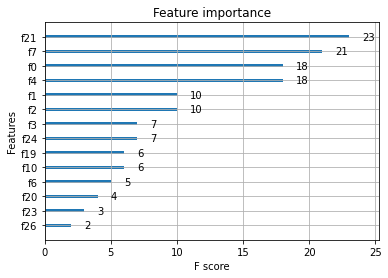

In [23]:
xgb.plot_importance(booster);

In [24]:
accuracy_score(y_test, y_pred)

0.8873732073115104

Za grupu 1 dobili smo točnost predikcije od 88.74%. Najvažniji indikatori su redom: `stat_194`, `stat_9`, `stat_1`, `stat_5`, `stat_2`, `stat_3`, `stat_4`, `stat_197`, `stat_192`, `stat_12`, `stat_8`, `stat_193` i `stat_196`.

### Modeling group2

Ponavljam isti postupak za grupu 2. Promijenio sam hiperparametre za treniranje jer je dataset za grupu 2 puno manji, pa mogu ići u veću dubinu stabla i zavrtiti više epoha.

In [27]:
df_x_rs = pd.read_csv('2020_group2_inp_rs.csv').values
df_y_rs = pd.read_csv('2020_group2_out_rs.csv').values
x_train, x_test, y_train, y_test = train_test_split(df_x_rs, df_y_rs, test_size=0.2, random_state=57)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'max_depth': 6, 
    'eta': 0.2, 
    'objective': 'binary:hinge',
    'nthread': 4,
    'eval_metric': 'auc'
}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
epochs = 15
booster = xgb.train(param, dtrain, epochs, evallist)

[0]	eval-auc:0.50000	train-auc:0.50000
[1]	eval-auc:0.50000	train-auc:0.50000
[2]	eval-auc:0.70371	train-auc:0.70270
[3]	eval-auc:0.70073	train-auc:0.70008
[4]	eval-auc:0.76372	train-auc:0.76225
[5]	eval-auc:0.79667	train-auc:0.79469
[6]	eval-auc:0.88463	train-auc:0.88532
[7]	eval-auc:0.87876	train-auc:0.87933
[8]	eval-auc:0.88212	train-auc:0.88261
[9]	eval-auc:0.89939	train-auc:0.90032
[10]	eval-auc:0.88509	train-auc:0.88559
[11]	eval-auc:0.90411	train-auc:0.90486
[12]	eval-auc:0.90723	train-auc:0.90791
[13]	eval-auc:0.90770	train-auc:0.90827
[14]	eval-auc:0.91634	train-auc:0.91691


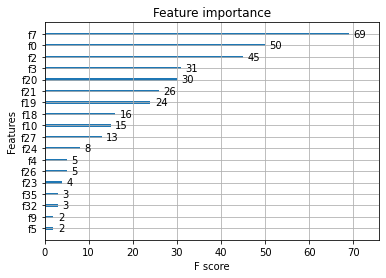

In [28]:
y_pred = booster.predict(dtest)
xgb.plot_importance(booster);

In [29]:
accuracy_score(y_test, y_pred)

0.916176617163361

 Točnost sa 15 epoha i *etom* = 0.2 iznosi 91.62%. Najvažniji indikatori su: `stat_9`, `stat_1`, `stat_3`, `stat_4`, `stat_193`, `stat_194`, `stat_192`, `stat_191`, `stat_12`, `stat_200`, `stat_197`, `stat_5` i `stat_199`.


### Modeling group3
Ponovo manji dataset, pa prilagođavam broj epoha na 45, da vidim kako se kreće točnost.

In [33]:
df_x_rs = pd.read_csv('2020_group3_inp_rs.csv').values
df_y_rs = pd.read_csv('2020_group3_out_rs.csv').values
x_train, x_test, y_train, y_test = train_test_split(df_x_rs, df_y_rs, test_size=0.4, random_state=22)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'max_depth': 4, 
    'eta': 0.22, 
    'objective': 'binary:hinge',
    'nthread': 4,
    'eval_metric': 'auc'
}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
epochs = 45
booster = xgb.train(param, dtrain, epochs, evallist)

[0]	eval-auc:0.50000	train-auc:0.50000
[1]	eval-auc:0.50000	train-auc:0.50000
[2]	eval-auc:0.91656	train-auc:0.91770
[3]	eval-auc:0.94596	train-auc:0.94773
[4]	eval-auc:0.94601	train-auc:0.94780
[5]	eval-auc:0.94617	train-auc:0.94793
[6]	eval-auc:0.94632	train-auc:0.94806
[7]	eval-auc:0.94617	train-auc:0.94790
[8]	eval-auc:0.94617	train-auc:0.94790
[9]	eval-auc:0.95576	train-auc:0.95733
[10]	eval-auc:0.95605	train-auc:0.95752
[11]	eval-auc:0.96379	train-auc:0.96447
[12]	eval-auc:0.96391	train-auc:0.96459
[13]	eval-auc:0.96410	train-auc:0.96477
[14]	eval-auc:0.96527	train-auc:0.96605
[15]	eval-auc:0.96515	train-auc:0.96589
[16]	eval-auc:0.96645	train-auc:0.96724
[17]	eval-auc:0.96774	train-auc:0.96814
[18]	eval-auc:0.97212	train-auc:0.97253
[19]	eval-auc:0.97329	train-auc:0.97377
[20]	eval-auc:0.97336	train-auc:0.97379
[21]	eval-auc:0.97613	train-auc:0.97659
[22]	eval-auc:0.97728	train-auc:0.97765
[23]	eval-auc:0.97934	train-auc:0.97952
[24]	eval-auc:0.98148	train-auc:0.98180
[25]	eval-

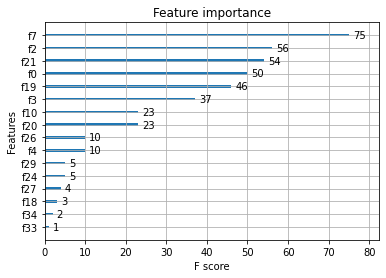

In [34]:
y_pred = booster.predict(dtest)
xgb.plot_importance(booster);

In [35]:
accuracy_score(y_test, y_pred)

0.9930354033662218

Za ovu skupinu dolazim do preko 99% točnosti. Najvažniji parametri su `stat_9`, `stat_3`, `stat_194`, `stat_1`, `stat_192`, `stat_4`, `stat_12`, `stat_193`, `stat_199` i `stat_5`.

### Modeling group4

In [36]:
df_x_rs = pd.read_csv('2020_group4_inp_rs.csv').values
df_y_rs = pd.read_csv('2020_group4_out_rs.csv').values
x_train, x_test, y_train, y_test = train_test_split(df_x_rs, df_y_rs, test_size=0.4, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'max_depth': 4, 
    'eta': 0.275, 
    'objective': 'binary:hinge',
    'nthread': 4,
    'eval_metric': 'auc'
}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
epochs = 10
booster = xgb.train(param, dtrain, epochs, evallist)

[22:54:24] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-auc:0.50000	train-auc:0.50000
[1]	eval-auc:0.50002	train-auc:0.50002
[2]	eval-auc:0.73245	train-auc:0.73230
[3]	eval-auc:0.76492	train-auc:0.76486
[4]	eval-auc:0.77022	train-auc:0.77016
[5]	eval-auc:0.84282	train-auc:0.84252
[6]	eval-auc:0.84193	train-auc:0.84167
[7]	eval-auc:0.84225	train-auc:0.84201
[8]	eval-auc:0.84410	train-auc:0.84385
[9]	eval-auc:0.84416	train-auc:0.84393


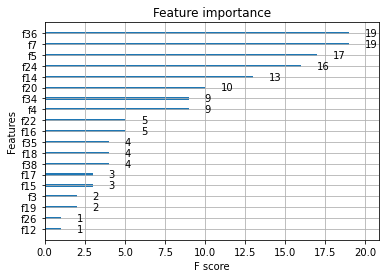

In [37]:
y_pred = booster.predict(dtest)
xgb.plot_importance(booster);

In [38]:
accuracy_score(y_test, y_pred)

0.8441305218964591

Za ovu, podacima najbogatiju skupinu, bilo je potrebno vratiti se na 10 epoha. Konačna točnost je 84.41%, a imamo i neke nove indikatore: `stat_242`, `stat_9`, `stat_7`, `stat_197`, `stat_187`, `stat_193`, `stat_240` i `stat_5`.

### Results by group

Uočavam da je jedan parametar u samome vrhu važnosti kod svakog grupnog modela, a to je `stat_9`. S obzirom da se radi o parametru koji uvijek samo raste s vremenom, dolazim do prirodnog zaključka da je **vjerojatnost kvara veća što je senzor dulje u uporabi**, s time da je uporaba ovog indikatora bolja nego primjena vremena, jer primjenom vremena gubimo informaciju koliki broj dana je senzor radio prije 1.1.2020.

Neki od ostalih važnijih indikatora su `stat_194`, `stat_197`, `stat_4` i `stat_5`.

### Modeling all
Za usporedbu, napravljen je SMOTE nad cjelovitim uzorkom, bez grupiranja, ali samo sa indikatorima koji su u zadatku navedeni kao prediktivni. Kod za generiranje podataka je sličan onome iznad, a podaci su pohranjeni u 2 datoteke, spremne za boosting model. Treniram:

In [2]:
df_x_rs = pd.read_csv('2020_reduced_inp_rs.csv').values
df_y_rs = pd.read_csv('2020_reduced_out_rs.csv').values
x_train, x_test, y_train, y_test = train_test_split(df_x_rs, df_y_rs, test_size=0.4, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'max_depth': 4, 
    'eta': 0.3, 
    'objective': 'binary:hinge',
    'nthread': 4,
    'eval_metric': 'auc'
}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
epochs = 10
booster = xgb.train(param, dtrain, epochs, evallist)

[23:23:06] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	eval-auc:0.50000	train-auc:0.50000
[1]	eval-auc:0.50002	train-auc:0.50002
[2]	eval-auc:0.87043	train-auc:0.87054
[3]	eval-auc:0.87601	train-auc:0.87607
[4]	eval-auc:0.87406	train-auc:0.87413
[5]	eval-auc:0.88020	train-auc:0.88033
[6]	eval-auc:0.88020	train-auc:0.88033
[7]	eval-auc:0.88022	train-auc:0.88035
[8]	eval-auc:0.88883	train-auc:0.88894
[9]	eval-auc:0.88886	train-auc:0.88897


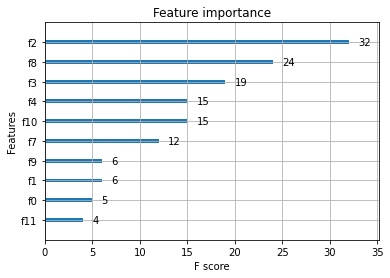

In [3]:
y_pred = booster.predict(dtest)
xgb.plot_importance(booster);

In [4]:
accuracy_score(y_test, y_pred)

0.888872771194193

Treniranjem nad prediktivnim indikatorima dobijem sličnu točnost kao i kad se ponderiraju točnosti po grupama, ukupno 88.89%. Glavni indikatori ovog pristupa su: `stat_3`, `stat_188`, `stat_4`, `stat_5`, `stat_197` i `stat_187`.